# Overview:
Training a classifier for sentiment analysis. I picked the Imdb dataset.


In [2]:
# This is a test to make sure that the notebook can be opened in my local machine -vs code.

print (f" Result: {5 + 2}")

 Result: 7


In [1]:
!pip3 install transformers
!pip3 install torch
!pip3 install flask
!pip3 install requests

!pip3 install matplotlib
!pip3 install pandas

     |████████████████████████████████| 7.1 MB 3.6 MB/s            
     |████████████████████████████████| 4.0 MB 34.0 MB/s            
     |████████████████████████████████| 236 kB 47.7 MB/s            
  Using cached PyYAML-6.0-cp38-cp38-macosx_10_9_x86_64.whl (192 kB)
     |████████████████████████████████| 160 kB 29.4 MB/s            
You should consider upgrading via the '/Users/negariravani/.pyenv/versions/3.8.9/envs/.mlprod_env/bin/python3.8 -m pip install --upgrade pip' command.
     |████████████████████████████████| 143.1 MB 163 kB/s             B/s eta 0:00:03███▋             | 83.4 MB 6.9 MB/s eta 0:00:09 ████             | 84.8 MB 6.9 MB/s eta 0:00:09 ██████████████████▏          | 94.4 MB 6.9 MB/s eta 0:00:08 :07 ██████████████▎      | 113.2 MB 43.9 MB/s eta 0:00:01 0:00:01
     |████████████████████████████████| 2.1 MB 19.5 MB/s            
     |████████████████████████████████| 5.7 MB 41.9 MB/s            ��███████████▋   | 5.1 MB 41.9 MB/s eta 0:00:01
     |████████

In [2]:
import os
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader


from google.colab import data_table
data_table.enable_dataframe_formatter()


# Data

In [3]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!mkdir -p data/raw
!tar -xf aclImdb_v1.tar.gz -C data/raw

--2023-06-02 17:31:29--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  16.3MB/s    in 9.2s    

2023-06-02 17:31:39 (8.70 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [4]:
def read_imdb_split(split_dir: str) -> pd.DataFrame:
    split_dir = Path(split_dir)
    texts, labels = [], []
    for label_dir in ["pos", "neg"]:
        for text_file in (split_dir/label_dir).iterdir():
            texts.append(text_file.read_text())
            labels.append(0 if label_dir == "neg" else 1)
    df = pd.DataFrame({"text": texts, "labels": labels})
    return df

In [5]:
# Subsample the data
os.makedirs("data/intrim", exist_ok=True)

# Load the dataset
df_train = read_imdb_split("data/raw/aclImdb/train")
df_test = read_imdb_split("data/raw/aclImdb/test")

print(f"Original Train dataset: {len(df_train)}, Test: {len(df_test)}")


Original Train dataset: 25000, Test: 25000


For the sake of this experiment, we use a subsample of train and test to speed up the process, we use 10% of train and 2% of test. also we put aside 20% of the train set as validation set.

In [6]:
df_train_val = df_train.sample(frac=.1, random_state=42)
df_train, df_val = train_test_split(df_train_val, test_size=.2)

df_test = df_test.sample(frac=.02, random_state=42)

df_train.to_csv("data/intrim/train.csv")
df_val.to_csv("data/intrim/val.csv")
df_test.to_csv("data/intrim/test.csv")

print(f"After subsampling train dataset: {len(df_train)}, Test: {len(df_test)}, Val: {len(df_val)}")

After subsampling train dataset: 2000, Test: 500, Val: 500


## Analysis

Text(0.5, 1.0, 'Test')

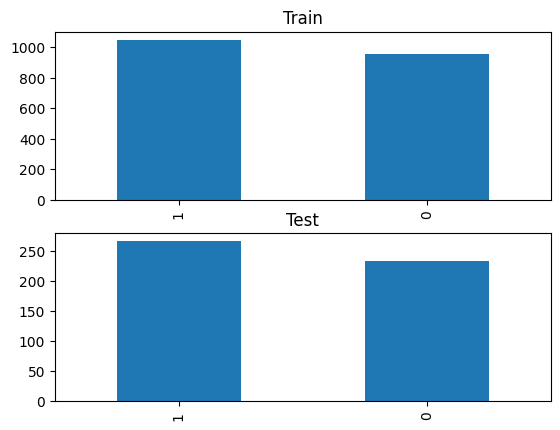

In [7]:
fig, axs = plt.subplots(2)
df_train.labels.value_counts().plot.bar(ax=axs[0])
axs[0].set_title("Train")
df_test.labels.value_counts().plot.bar(ax=axs[1])
axs[1].set_title("Test")

** The dataset is quite balanced. and therefore we will not consider any class weights for positive vs negative samples.

In [8]:
df_train.head()

,text,labels
8299,"There are movies, and there are films. Movies ...",1
3382,One of my favorite films for a number of years...,1
20523,It feels like swedish movies are trying to bec...,0
5532,I waited until the 4th of July to write this b...,1
10890,Bacall does well here - especially considering...,1


The text is pretty clean, there are some occational new lines. a transformer model will work in presence of these characters pretty easily, but we just delete that.

In [9]:
def clean_text(text):
  return text.replace("<br />", "")
df_train["text_processed"] = df_train.text.apply(lambda txt: clean_text(txt))
df_val["text_processed"] = df_val.text.apply(lambda txt: clean_text(txt))

## Model development

### Baseline
We will start with a baseline model to get an idea.

In [10]:
# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data and transform the data
X_train_vectorized = vectorizer.fit_transform(df_train["text_processed"])
X_val_vectorized = vectorizer.transform(df_val["text_processed"])

print(f"Number of words in the vocab: {len(vectorizer.vocabulary_)}")

# Create a logistic regression classifier
classifier = LogisticRegression()

# Train the classifier on the vectorized training data
_ = classifier.fit(X_train_vectorized, df_train["labels"])


Number of words in the vocab: 26130


Val Accuracy: 0.83
Train Accuracy: 0.94


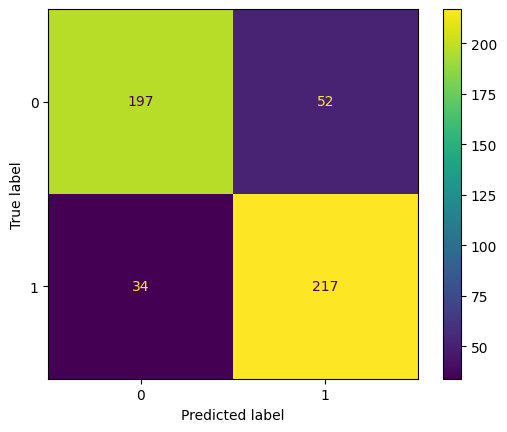

In [11]:
df_train["predictions_baseline"] = classifier.predict(X_train_vectorized)
df_val["predictions_baseline"] = classifier.predict(X_val_vectorized)

# Calculate the accuracy of the model
accuracy = accuracy_score(df_val["labels"], df_val["predictions_baseline"])
print(f"Val Accuracy: {accuracy:.2f}")

# Calculate the accuracy of the model
accuracy = accuracy_score(df_train["labels"], df_train["predictions_baseline"])
print(f"Train Accuracy: {accuracy:.2f}")

cm = confusion_matrix(df_val["labels"], df_val["predictions_baseline"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

The model is slightly overfitted and we can add more regularization to it. but we are going to move forward for now. note that since the data is balanced, accuracy can be used as a metric.

### Transformer based

will use the distilbert which is the lightweighted version of bert using Knowledge distillation.

Token indices sequence length is longer than the specified maximum sequence length for this model (973 > 512). Running this sequence through the model will result in indexing errors


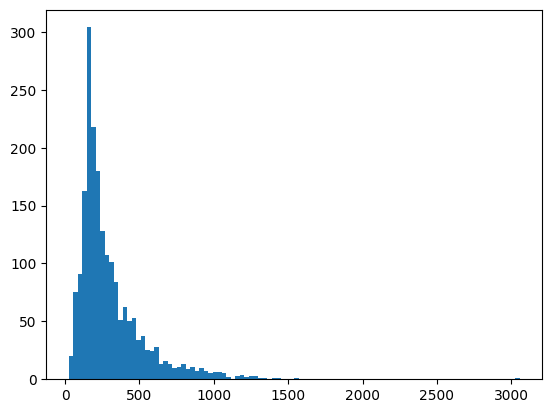

In [12]:
model_ckp = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckp)
train_encodings = tokenizer(df_train["text_processed"].tolist(), truncation=False, padding=False)
_ = plt.hist([len(encoding) for encoding in train_encodings["input_ids"]], bins=100)

#### Data Tokenization


- some points: </br>
1 - A simplification: we are trunctuaing text. so if it is larger than 512 tokens(the maximum accepted length by distilbert) we are cutting if off. here this is not a problem. since the sentiment of a review will __probably__ be the same during the whole text and the first 512 tokens will be enough to capture that. ofcourse this can be a wrong assumption, for example if at first the reviewer is talking about positive things and at the end (the cut off portion) about negative things and the whole sentiment is negative.</br>
2- Here we are not padding the whole data altogether. We are planning to use dynamic padding. The reason is that this is an important issue if we are concerned about training speed (and compute and cost) and also when the inference is happening at batch mode. the transformer speed is dependant on (sequence length) ** 2. If we pad here all the exmaples are going to be 512. while in dynamic padding, we pad the examples to the longest sequence length in the batch. We will define a padding data collator.

In [13]:
model_ckp = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckp)
train_encodings = tokenizer(df_train["text_processed"].tolist(), truncation=True)
val_encodings = tokenizer(df_val["text_processed"].tolist(), truncation=True)

#### Dataset creation

In [14]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
train_dataset = IMDbDataset(train_encodings, df_train["labels"].tolist())
val_dataset = IMDbDataset(val_encodings, df_val["labels"].tolist())


#### Data Collator

In [16]:
class DataCollatorWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
      tokenizer: Any of the HF tokenizer 
    """
    def __init__(self, tokenizer):
      self.tokenizer = tokenizer
    def __call__(self, features: list[dict[str, int|list]]) -> dict[str, int|list]:
        batch = self.tokenizer.pad(features, padding="longest", return_tensors="pt")
        return batch

In [17]:
data_collator = DataCollatorWithPadding(tokenizer)

#### Data Loader

In [18]:
# since we are not keeping gradients we can go to higher batch for validation
train_bs, val_bs = 16, 8
train_loader = DataLoader(train_dataset, batch_size=train_bs, collate_fn=data_collator, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=val_bs, collate_fn=data_collator, shuffle=False)

In [19]:
sample = next(iter(train_loader))
print (sample["input_ids"].shape)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


torch.Size([16, 512])


#### Load model

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device)
model.train()

cuda


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

#### Training
The training process will take around 4 minutes.

In [21]:
# Convention to use AdamW for training transformers

learning_rate = 5e-5
num_epochs = 3
model_path = "trained_imdb_sentiment"
optim = AdamW(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    loss_total = 0
    for batch in tqdm(train_loader):
        optim.zero_grad()
        batch = {key: value.to(device) for key, value in batch.items()}
        outputs = model(**batch)
        # The default loss is Binary cross Entropy loss, no need to change that
        loss = outputs[0]
        loss.backward()
        optim.step()
        loss_total += loss.item()
    print(f"\nEpoch {epoch} Loss {loss_total}")
  
# Savin the model
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 125/125 [01:29<00:00,  1.40it/s]



Epoch 0 Loss 50.64929635077715


100%|██████████| 125/125 [01:30<00:00,  1.38it/s]



Epoch 1 Loss 24.84263265505433


100%|██████████| 125/125 [01:33<00:00,  1.34it/s]



Epoch 2 Loss 8.793289381079376


#### Evaluation

In [22]:
# since we're not training, we don't need to calculate the gradients for our outputs
predictions = []
with torch.no_grad():
    for batch in tqdm(val_loader):
        # calculate outputs by running images through the network
        batch = {key: value.to(device) for key, value in batch.items()}
        outputs = model(**batch)
        predictions.append(torch.argmax(outputs.logits, axis=1).detach().cpu().numpy().tolist())

100%|██████████| 63/63 [00:08<00:00,  7.49it/s]


Text(0.5, 1.0, 'accuray: 0.9385')

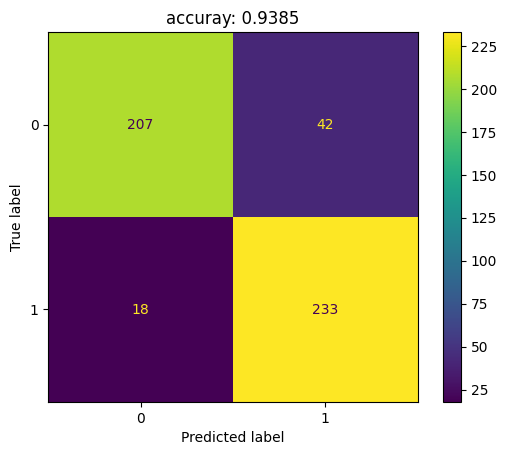

In [23]:
predictions_list = [item for sublist in predictions for item in sublist]
cm = confusion_matrix(df_val["labels"], predictions_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
Accuracy = accuracy_score(df_val["labels"], predictions_list)
plt.title(f"accuray: {accuracy}")


Thransformer based model outperforms classical machine learning ones (obviousely)

#### Inference

In [27]:
class Inferencer:
  def __init__(self, model_dir: str):
    self.tokenizer = AutoTokenizer.from_pretrained(model_dir)
    self.model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(self.device)
    model.eval()
  
  def preprocess_text(self, text: str) -> str:
    return clean_text(text)
  
  def run(self, text: str) -> int:
    text = self.preprocess_text(text)
    encodes = self.tokenizer([text], truncation=True, return_tensors="pt")
    encodes = {key: value.to(device) for key, value in encodes.items()}
    output = model(**encodes)
    return torch.argmax(output.logits).cpu().item()


In [28]:
infer = Inferencer(model_path)

In [29]:
for i in range(3):
  sample = df_test.iloc[i]["text"]
  label = df_test.iloc[i]["labels"]
  pred = infer.run(sample)
  print (sample)
  print (pred, label)
  print ("*"*20)


I saw this movie alone when i was an early teen in my hometown in India, at a time when the only thing that fascinated me aside from girls were Tigers. I came home after watching it, with a glazed look in my eye, wanting to be that bloke in the movie that befriended the Tigers. What a movie and what a moment that was! The theatre I saw it in does not exist any and has given way to a shopping mall. I don't know how i'd feel about it now after so many years and do not want to spoil a childhood memory by finding this movie available on DVD or something similar and not finding it interesting anymore. I have learned from previous experience that a childhood memory is often tarnished when one travels life's jaded highways occasionally trying to rediscover their unadulterated past by way of movies, only to find its gushing innocence completely soppy and not welcome anymore. And I do not want to throw away the experiences of a memory of this movie into the wind. I do not have kids, so i probab

### Future steps

- we should have an analysis stage. look at examples that we are making mistakes about. See whether we are making any systematic error. </br>

- This was just one pass of training. we should tweak the important parameters like learning rate. </br>

- the training loop needs more observability. it would be nice to know the validation accuracy as we are training.
<br>

- create a simple demo with gradio as it is easier to go over some examples and get some insight.

### create a simple web server
for the sake of having everything in the same place, instead of a seperate python file, we will put the code for server here.


In [38]:
from flask import Flask, request, jsonify

MODEL_PATH = "trained_imdb_sentiment"


app = Flask('sentiment-analysis')

infer = Inferencer(MODEL_PATH)

@app.route('/predict', methods=['POST'])
def predict_endpoint():
    data = request.get_json()

    pred = infer.run(data["text"])

    result = {'sentiment': pred}

    return jsonify(result)

if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app 'sentiment-analysis'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat


In [37]:
sample = df_test.iloc[0]["text"]
print (df_test.iloc[0]["labels"], "\n", sample)

1 
 I saw this movie alone when i was an early teen in my hometown in India, at a time when the only thing that fascinated me aside from girls were Tigers. I came home after watching it, with a glazed look in my eye, wanting to be that bloke in the movie that befriended the Tigers. What a movie and what a moment that was! The theatre I saw it in does not exist any and has given way to a shopping mall. I don't know how i'd feel about it now after so many years and do not want to spoil a childhood memory by finding this movie available on DVD or something similar and not finding it interesting anymore. I have learned from previous experience that a childhood memory is often tarnished when one travels life's jaded highways occasionally trying to rediscover their unadulterated past by way of movies, only to find its gushing innocence completely soppy and not welcome anymore. And I do not want to throw away the experiences of a memory of this movie into the wind. I do not have kids, so i pr

In [ ]:
# Make a call form another python script or from terminal using curl
import requests

url = 'http://localhost:5000/predict'
r = requests.post(url,json={'text': sample})

print(r.json())